In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tdt
import trompy as tp

import dill

In [ ]:
DATAFOLDER = Path("..//data")
TANKFOLDER = Path("D://TestData//bazzino//to McCutcheon from Paula Bazzino")
DLCFOLDER = TANKFOLDER / "Sodium_Appetite_DLC"

metadata = pd.read_csv(DATAFOLDER / "10NaCl_FileKey.csv")

read from t=0s to t=2626.46s
2240 values set to NaN for rightear_x rightear_y
3910 values set to NaN for nose_x nose_y
3807 values set to NaN for tailbase_x tailbase_y
3801 values set to NaN for leftear_x leftear_y


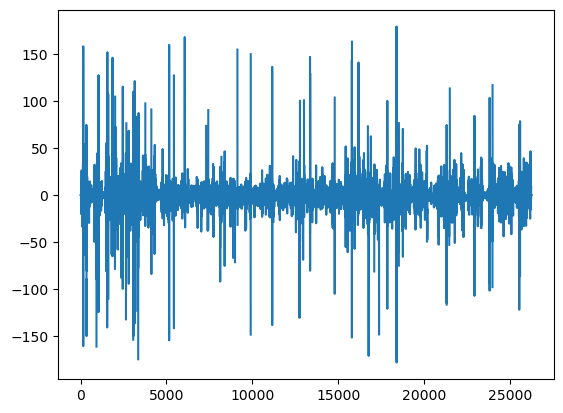

In [97]:
def get_ttls(stub):

    # Get the TTLs
    data = tdt.read_block(TANKFOLDER / stub, evtype=["epocs"])
    sol = data.epocs.sol_.onset
    
    return sol

def read_DLC_csv(filename):
    
    header_df = pd.read_csv(filename, skiprows=1, nrows=2, header=None)
    
    row2_values = header_df.iloc[0].astype(str) # This is original row 2
    row3_values = header_df.iloc[1].astype(str) # This is original row 3
    
    new_column_names = [f"{val2.lower().replace(' ', '')}_{val3}" for val2, val3 in zip(row2_values, row3_values)]
    
    df = pd.read_csv(filename, skiprows=3, header=None, names=new_column_names)
    
    return df

def interpolate_low_likehood(df, threshold=0.5):
    # Convert all columns to numeric, coercing errors. This is important.
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Identify unique bodyparts mentioned in the columns
    bodyparts = set()
    for col_name in df.columns:
        parts = col_name.split('_')
        if len(parts) > 1: # e.g., leftear_x, leftear_likelihood
            bodyparts.add(parts[0]) 
    
    # For each bodypart, interpolate x and y based on likelihood
    for bp in bodyparts:
        x_col = f"{bp}_x"
        y_col = f"{bp}_y"
        likelihood_col = f"{bp}_likelihood"

        if x_col in df.columns and y_col in df.columns and likelihood_col in df.columns:
            # Condition where likelihood is below threshold
            condition = df[likelihood_col] < threshold
            
            # Set x and y to NaN based on the condition
            df.loc[condition, x_col] = np.nan
            df.loc[condition, y_col] = np.nan
            
            print(np.sum(condition), "values set to NaN for", x_col, y_col)
            
            # Interpolate the x and y columns (linear interpolation by default)
            df[x_col] = df[x_col].interpolate(method='linear', limit_direction='both')
            df[y_col] = df[y_col].interpolate(method='linear', limit_direction='both')
        # else:
            # print(f"Warning: Missing x, y, or likelihood columns for bodypart '{bp}' in {filename.name}")

    return df

def calc_angular_velocity(df):
    
    return (
        df
        .assign(
            _rel_rightear_x_orig = lambda x_df: x_df.rightear_x - x_df.leftear_x,
            _rel_rightear_y_orig = lambda x_df: x_df.rightear_y - x_df.leftear_y
        )
        .assign(
            ear_distance = lambda x_df: np.sqrt(x_df._rel_rightear_x_orig**2 + x_df._rel_rightear_y_orig**2)
        )
        .assign(
            rel_rightear_x = lambda x_df: np.where(x_df.ear_distance >= 90, np.nan, x_df._rel_rightear_x_orig),
            rel_rightear_y = lambda x_df: np.where(x_df.ear_distance >= 90, np.nan, x_df._rel_rightear_y_orig)
        )
        .assign(
            angle_rad = lambda x_df: np.arctan2(x_df.rel_rightear_y, x_df.rel_rightear_x)
        )
        .assign(
            _d_angle_raw = lambda x_df: x_df.angle_rad.diff()
        )
        .assign(
            d_angle = lambda x_df: x_df._d_angle_raw.fillna(0),
            d_angle_wrapped = lambda x_df: (x_df._d_angle_raw + np.pi) % (2 * np.pi) - np.pi
        )
        .assign(
            d_angle_deg = lambda x_df: np.rad2deg(x_df.d_angle_wrapped)
        )
        .drop(columns=['_rel_rightear_x_orig', '_rel_rightear_y_orig', '_d_angle_raw'], errors='ignore')
    )
    
def get_angular_velocity(stub):
    
    date = stub.split("-")[1]
    
    filename = DLCFOLDER / f"PB_NAapp-{date}_{stub}_Cam1DLC_resnet50_Raw_VideosMar27shuffle1_50000.csv"
    # Get the angular velocity
    
    df = read_DLC_csv(filename)
    
    df = interpolate_low_likehood(df, threshold=0.5)

    df = calc_angular_velocity(df)

    # Plot the angular velocity
    plt.plot(df.d_angle_deg)
    
    return df.d_angle_deg

def get_ang_vel_snips(stub):
    # Get the angular velocity snips
    
    sol = get_ttls(stub)
    v = get_angular_velocity(stub)
    
    snips_vel = []
    for i in range(len(sol)-1):
        start = int(sol[i] * 10) - 50
        end = int(sol[i] * 10) + 150
        snips_vel.append(v[start:end])
        
    snips_vel = np.array(snips_vel)
    
    snips_vel = tp.zscore(snips_vel, baseline_points=50)
    
    return np.array(snips_vel)

stub = "PB27-220608-104154"

snips_vel = get_ang_vel_snips(stub)
    
    
    

PB23-220608-131619
read from t=0s to t=2614.16s
1498 values set to NaN for rightear_x rightear_y
4190 values set to NaN for nose_x nose_y
701 values set to NaN for tailbase_x tailbase_y
2746 values set to NaN for leftear_x leftear_y
49
PB24-220608-122638
read from t=0s to t=2643.15s
6121 values set to NaN for rightear_x rightear_y
7605 values set to NaN for nose_x nose_y
3008 values set to NaN for tailbase_x tailbase_y
6049 values set to NaN for leftear_x leftear_y
49
PB33-220620-115414
read from t=0s to t=2616.75s
841 values set to NaN for rightear_x rightear_y
1200 values set to NaN for nose_x nose_y
319 values set to NaN for tailbase_x tailbase_y
720 values set to NaN for leftear_x leftear_y
49
PB39-220629-105034
read from t=0s to t=2679.85s
351 values set to NaN for rightear_x rightear_y
824 values set to NaN for nose_x nose_y
577 values set to NaN for tailbase_x tailbase_y
495 values set to NaN for leftear_x leftear_y
49
PB391-220829-111452
read from t=0s to t=2683.06s
1350 values

c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\tdt\TDTbin2py.py:1437: Warning: sss/ buddy epoc not found, skipping
  warnings.warn(epocs.buddies[ii] + ' buddy epoc not found, skipping', Warning)


read from t=0s to t=2651.47s
2126 values set to NaN for rightear_x rightear_y
1857 values set to NaN for nose_x nose_y
1380 values set to NaN for tailbase_x tailbase_y
1866 values set to NaN for leftear_x leftear_y
49
PB62-221022-103215
read from t=0s to t=2638.67s
1002 values set to NaN for rightear_x rightear_y
1213 values set to NaN for nose_x nose_y
729 values set to NaN for tailbase_x tailbase_y
1098 values set to NaN for leftear_x leftear_y
49
PB64-221022-112221
read from t=0s to t=2673.06s
1410 values set to NaN for rightear_x rightear_y
1648 values set to NaN for nose_x nose_y
1130 values set to NaN for tailbase_x tailbase_y
1455 values set to NaN for leftear_x leftear_y
49
PB70-221022-121226
read from t=0s to t=2531.26s
2366 values set to NaN for rightear_x rightear_y
3016 values set to NaN for nose_x nose_y
2142 values set to NaN for tailbase_x tailbase_y
2515 values set to NaN for leftear_x leftear_y
49
PB39-220705-114000
read from t=0s to t=2660.96s
Error with tank for PB39

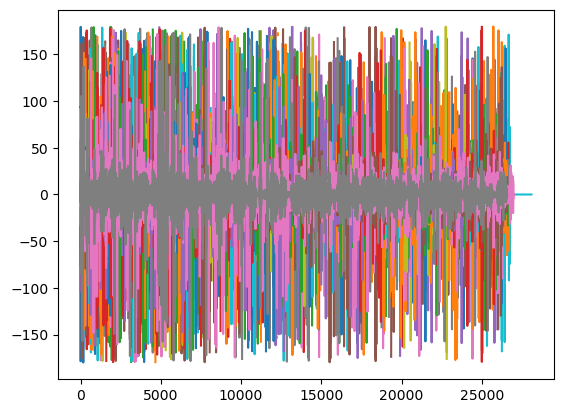

In [113]:
# also make accompanying df that contains details of the rat and the condition and the time in session

def assemble_all_data(csv_path, tank_folder, dlc_folder):
    metadata = pd.read_csv(csv_path)
    
    snips_array = []
    x_array = []
    
    for row in metadata.iterrows():
        stub = row[1]["Folder"]
        
        print(stub)
        try:
            
            snips_tmp = get_ang_vel_snips(stub)
            nsnips = len(snips_tmp)
            print(nsnips)
            snips_array.append(snips_tmp)
            
            x_array.append(pd.DataFrame(data={"trial": np.arange(nsnips),
                                              "id": row[1]["Subject"],
                                              "condition": row[1]["Physiological state"]
                                             }
                                       )
                          )           
        except:
            print("Error with tank for", row[1]["Subject"], row[1]['Physiological state'])
        
    return snips_array, x_array

snips_10NaCl, x_10NaCl = assemble_all_data(DATAFOLDER / "10NaCl_FileKey.csv", TANKFOLDER, DLCFOLDER)
snips_45NaCl, x_45NaCl = assemble_all_data(DATAFOLDER / "45NaCl_FileKey.csv", TANKFOLDER, DLCFOLDER)

snips_10NaCl = np.concatenate(snips_10NaCl, axis=0)
snips_45NaCl = np.concatenate(snips_45NaCl, axis=0)

In [114]:
def tweak_x_array(x_array):

    df = pd.concat(x_array, axis=0)

    return (df
            .replace({"condition": {"Sodium Depleted": "deplete",
                                    "Sodium Replete": "replete",
                                    "Sodium Replete Experienced": "replete_exp",
                                    "Thirsty": "thirsty",                                    
                                    }})
            )

x_10NaCl = tweak_x_array(x_10NaCl)
x_45NaCl = tweak_x_array(x_45NaCl)

In [115]:
# code to only select the conditions we want - deplete and replete

snips_10NaCl_selected = snips_10NaCl[(x_10NaCl.condition != "thirsty") & (x_10NaCl.condition != "replete_exp")]
snips_45NaCl_selected = snips_45NaCl[(x_45NaCl.condition != "thirsty") & (x_45NaCl.condition != "replete_exp")]

x_10NaCl_selected = x_10NaCl.query("condition != 'thirsty' & condition != 'replete_exp'")
x_45NaCl_selected = x_45NaCl.query("condition != 'thirsty' & condition != 'replete_exp'")

In [116]:
# combines with data from subjects csv to get add sex

subjects_10NaCl = pd.read_csv(DATAFOLDER / "10NaCl_SubjectKey.csv")
subjects_45NaCl = pd.read_csv(DATAFOLDER / "45NaCl_SubjectKey.csv")

subject_df = (pd.concat([subjects_10NaCl.iloc[:, :2], subjects_45NaCl.iloc[:, :2]], axis=0)
              .reset_index()
              .rename(columns={"Subject": "id",
                               "Sex": "sex"})
              .drop(columns=["index"])
)

x_vel_10NaCl = x_10NaCl_selected.assign(infusiontype="10NaCl")
x_vel_45NaCl = x_45NaCl_selected.assign(infusiontype="45NaCl")

x_vel = pd.concat([x_vel_10NaCl, x_vel_45NaCl]).reset_index(drop=True)

x_vel = pd.merge(x_vel, subject_df[['id', 'sex']], on='id', how='left')


In [117]:
with open(DATAFOLDER / "x_angvel.pickle", "wb") as f:
    dill.dump(x_vel, f)

In [120]:
snips_vel_all = np.vstack([snips_10NaCl_selected, snips_45NaCl_selected])
snips_vel_all = np.abs(snips_vel_all)

with open(DATAFOLDER / "snips_angvel.pickle", "wb") as f:
    dill.dump(snips_vel_all, f)